In [ ]:
!pip install SimpleITK

In [ ]:
!pip install torch torchvision


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, random_split
from torchvision import transforms, models
from torchvision.models.segmentation import deeplabv3_resnet101
from PIL import Image
import os
import matplotlib.pyplot as plt

# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load the pre-trained DeepLabV3 model
model = deeplabv3_resnet101(pretrained=True)
model.classifier[4] = nn.Conv2d(256, 1, kernel_size=(1, 1), stride=(1, 1))  # Change the classifier to output single channel for mask
model.to(device)


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DeepLabV3_ResNet101_Weights.COCO_WITH_VOC_LABELS_V1`. You can also use `weights=DeepLabV3_ResNet101_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


DeepLabV3(
  (backbone): IntermediateLayerGetter(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Se

In [ ]:
import os
import numpy as np
import tensorflow as tf
#from tf.keras.preprocessing.image import load_img, img_to_array
from sklearn.model_selection import train_test_split
from google.colab import drive
drive.mount('/content/drive/')
import SimpleITK as sitk
#from radiomics import featureextractor
import numpy as np
import pandas as pd



def get_image_mask(folder):
    """
    Generates pairs of original images and corresponding masks from a folder.
    """
    image_files = {}
    mask_files = {}

    for filename in os.listdir(folder):
        if filename.endswith('.png'):
            if '_mask' in filename:
                # Extract number to match masks and images
                number_masks = filename.split('(')[1].split(')')[0]
                mask_files[number_masks] = os.path.join(folder, filename)

            else:
                number_originals = filename.split('(')[1].split(')')[0]
                image_files[number_originals] = os.path.join(folder, filename)
    return mask_files, image_files

'''
benign = get_image_mask('/content/drive/MyDrive//benign_deleted')
mask_files_benign, image_files_benign = benign
malignant = get_image_mask('/content/drive/MyDrive/myData/healthcare#2/malignant_deleted')
mask_files_malignant, image_files_malignant = malignant'''

# kerem paths
benign_dir = ('/content/drive/MyDrive/benign_deleted')
malignant_dir = ('/content/drive/MyDrive/malignant_deleted')

benign = get_image_mask('/content/drive/MyDrive/benign_deleted')

mask_files_benign, image_files_benign = benign
malignant = get_image_mask('/content/drive/MyDrive/malignant_deleted')
mask_files_malignant, image_files_malignant = malignant

#image_files = dict(list(image_files_benign.items()) + list(malignant.items()))

masks = mask_files_benign.copy()
masks.update(mask_files_malignant)


originals = image_files_benign.copy()
originals.update(image_files_malignant)

print(len(mask_files_malignant))
print(len(image_files_malignant))
print(len(mask_files_benign))
print(len(image_files_benign))

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).
165
165
350
350


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from torchvision import transforms
from torch.utils.data import Dataset, random_split
from PIL import Image
import os

# Parameters
IMG_HEIGHT = 256
IMG_WIDTH = 256
BATCH_SIZE = 4
EPOCHS = 4
LEARNING_RATE = 0.01

class CancerDataset(Dataset):
    def __init__(self, image_dir, transform=None):
        self.image_dir = image_dir
        self.transform = transform
        self.image_files = [f for f in os.listdir(image_dir) if f.endswith('.png') and not f.endswith('_mask.png')]

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_name = self.image_files[idx]
        img_path = os.path.join(self.image_dir, img_name)
        mask_name = img_name.replace('.png', '_mask.png')
        mask_path = os.path.join(self.image_dir, mask_name)

        image = Image.open(img_path).convert('RGB')
        mask = Image.open(mask_path).convert('L')

        if self.transform:
            image = self.transform(image)
            mask = self.transform(mask)

        return image, mask

# Define transformations
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
])

# Create datasets
benign_dataset = CancerDataset(benign_dir, transform=transform)
malignant_dataset = CancerDataset(malignant_dir, transform=transform)

# Combine datasets
combined_dataset = torch.utils.data.ConcatDataset([benign_dataset, malignant_dataset])

# Split dataset into training, validation, and test sets
train_size = int(0.7 * len(combined_dataset))
val_size = int(0.15 * len(combined_dataset))
test_size = len(combined_dataset) - train_size - val_size

train_dataset, val_dataset, test_dataset = random_split(combined_dataset, [train_size, val_size, test_size])

# Create data loaders
BATCH_SIZE = 4
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)


In [ ]:
# Unfreeze some layers
for param in model.backbone.parameters():
    param.requires_grad = False

for param in model.classifier.parameters():
    param.requires_grad = True

# Define the loss function and optimizer
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=0.001)


In [ ]:
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=4):
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for images, masks in train_loader:
            images = images.to(device)
            masks = masks.to(device)

            # Forward pass
            outputs = model(images)['out']
            loss = criterion(outputs, masks)

            # Backward pass and optimization
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        epoch_loss = running_loss / len(train_loader)
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}")

        # Validation step
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for images, masks in val_loader:
                images = images.to(device)
                masks = masks.to(device)

                outputs = model(images)['out']
                loss = criterion(outputs, masks)
                val_loss += loss.item()

        val_loss /= len(val_loader)
        print(f"Validation Loss: {val_loss:.4f}")

train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=15)


Epoch [1/15], Loss: 0.0943
Validation Loss: 0.1668
Epoch [2/15], Loss: 0.0953
Validation Loss: 0.1819
Epoch [3/15], Loss: 0.0858
Validation Loss: 0.1712
Epoch [4/15], Loss: 0.0797
Validation Loss: 0.1666
Epoch [5/15], Loss: 0.0773
Validation Loss: 0.1530
Epoch [6/15], Loss: 0.0773
Validation Loss: 0.1515
Epoch [7/15], Loss: 0.0756
Validation Loss: 0.1680
Epoch [8/15], Loss: 0.0719
Validation Loss: 0.1941
Epoch [9/15], Loss: 0.0694
Validation Loss: 0.2083
Epoch [10/15], Loss: 0.0684
Validation Loss: 0.1774
Epoch [11/15], Loss: 0.0635
Validation Loss: 0.1660
Epoch [12/15], Loss: 0.0656
Validation Loss: 0.1902
Epoch [13/15], Loss: 0.0642
Validation Loss: 0.2016
Epoch [14/15], Loss: 0.0591
Validation Loss: 0.1855
Epoch [15/15], Loss: 0.0599
Validation Loss: 0.1827


In [ ]:
# Save the trained model
torch.save(model.state_dict(), 'deeplabv3_resnet101_finetuned.pth')


In [ ]:
def calculate_iou(pred_mask, true_mask, threshold=0.5):
    pred_mask = (pred_mask > threshold).bool()
    true_mask = true_mask.bool()
    intersection = (pred_mask & true_mask).float().sum((1, 2))
    union = (pred_mask | true_mask).float().sum((1, 2))
    iou = (intersection + 1e-6) / (union + 1e-6)
    return iou.mean().item()


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
threshold =0.3

def test_model(model, test_loader, device, threshold=threshold):
    model.eval()
    ious = []

    with torch.no_grad():
        for images, masks in test_loader:
            images = images.to(device)
            masks = masks.to(device)

            outputs = model(images)['out']
            outputs = torch.sigmoid(outputs)

            # Calculate IoU for each batch
            batch_iou = calculate_iou(outputs, masks, threshold)
            ious.append(batch_iou)

    mean_iou = np.mean(ious)
    print(f'Mean IoU on test set: {mean_iou:.4f}')
    return mean_iou

# Load the trained model for inference
model.load_state_dict(torch.load('deeplabv3_resnet101_finetuned.pth'))
model.to(device)

# Evaluate the model on the test set
mean_iou = test_model(model, test_loader, device, threshold)


Mean IoU on test set: 0.7146


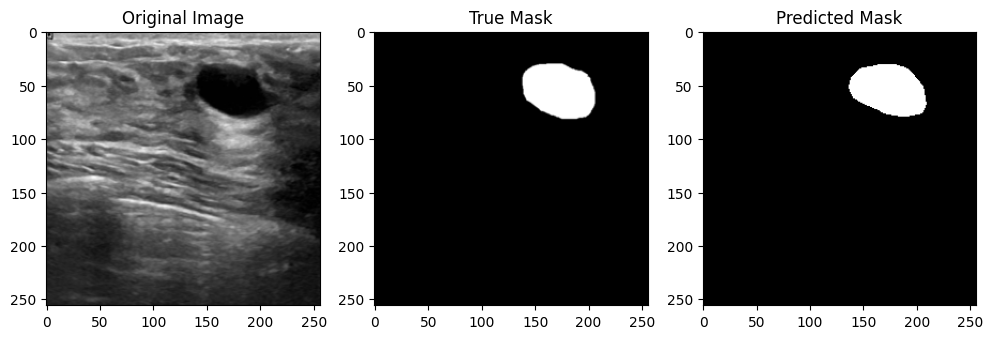

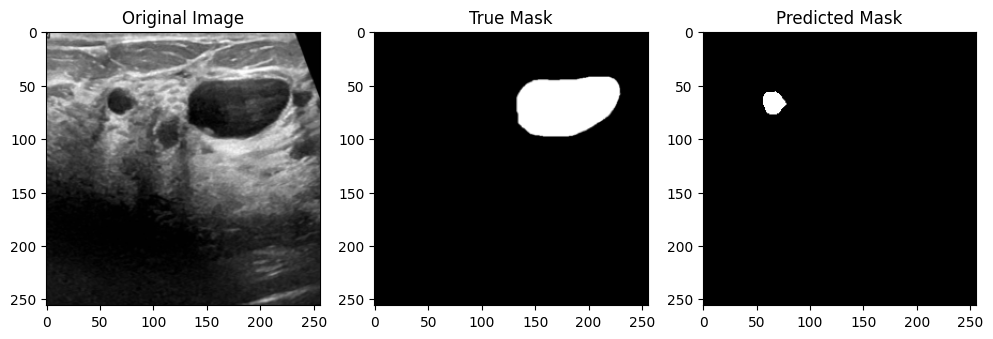

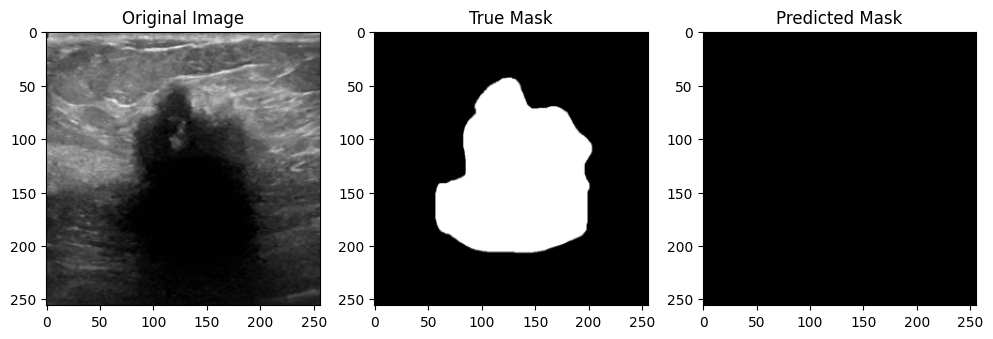

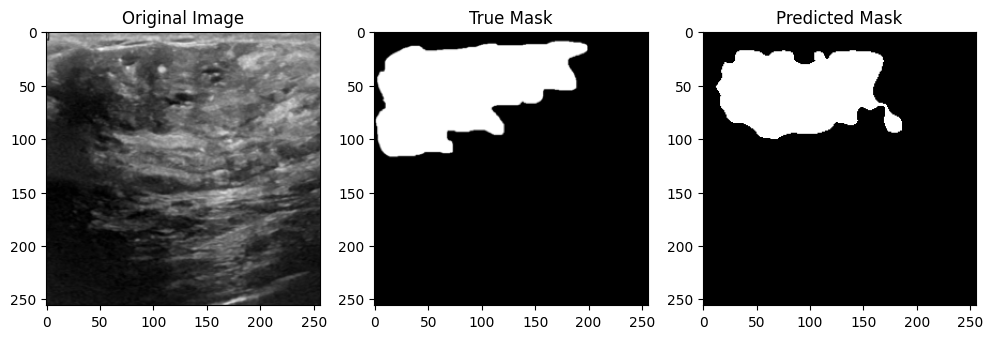

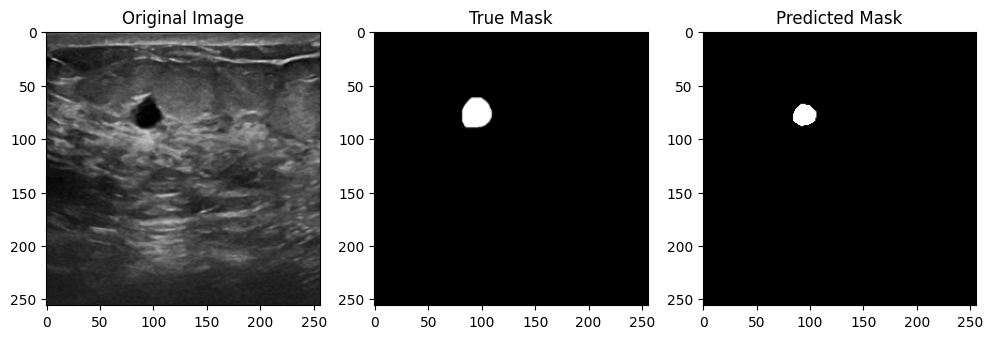

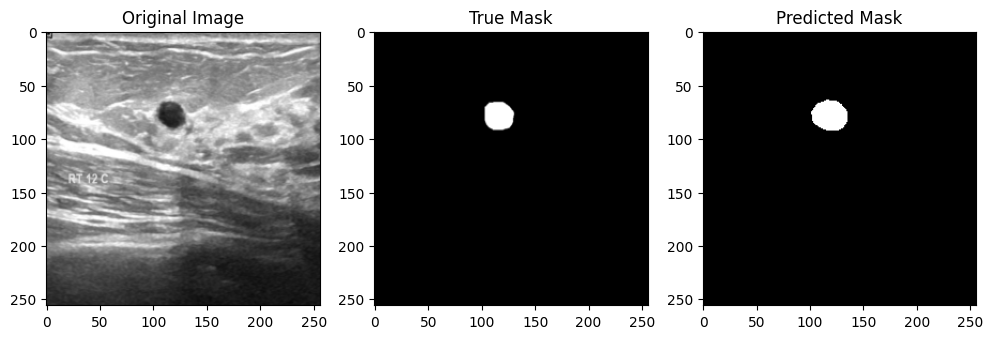

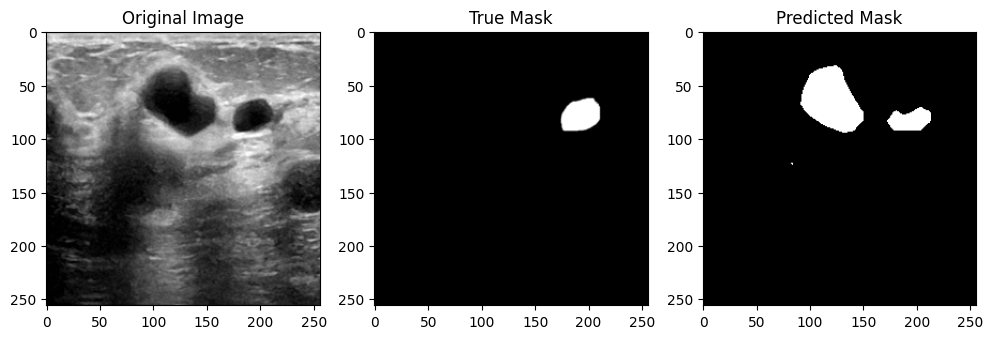

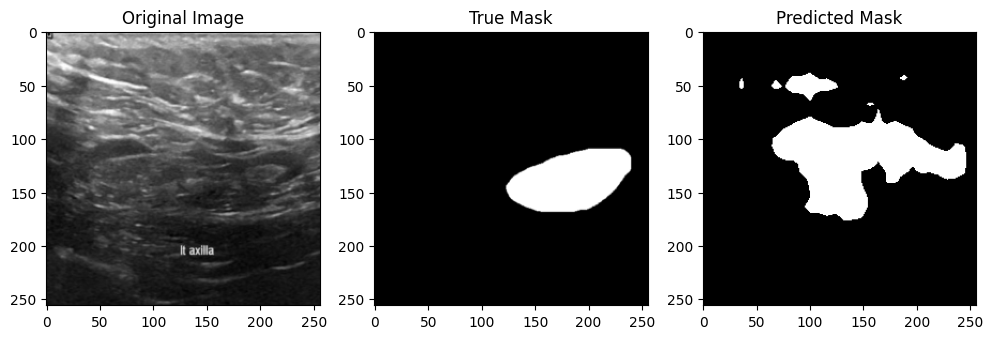

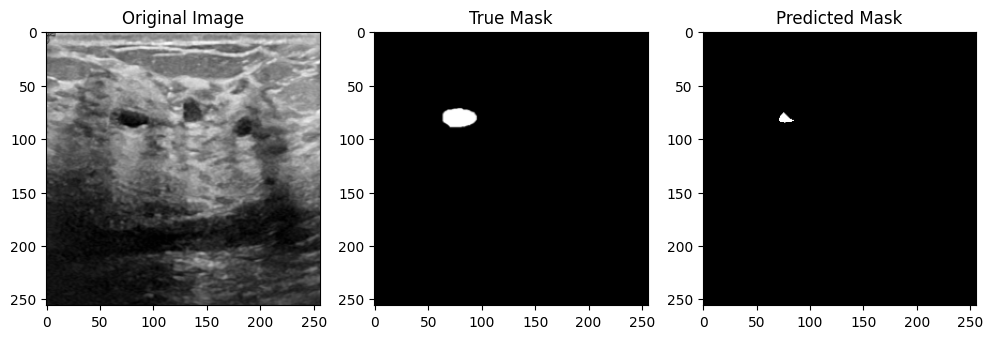

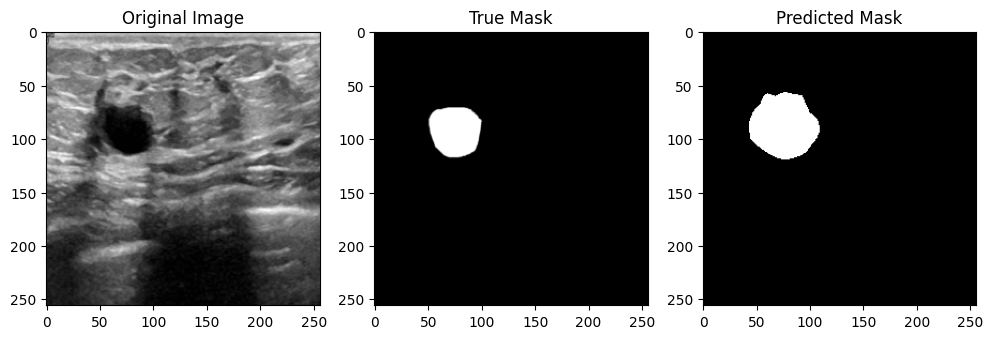

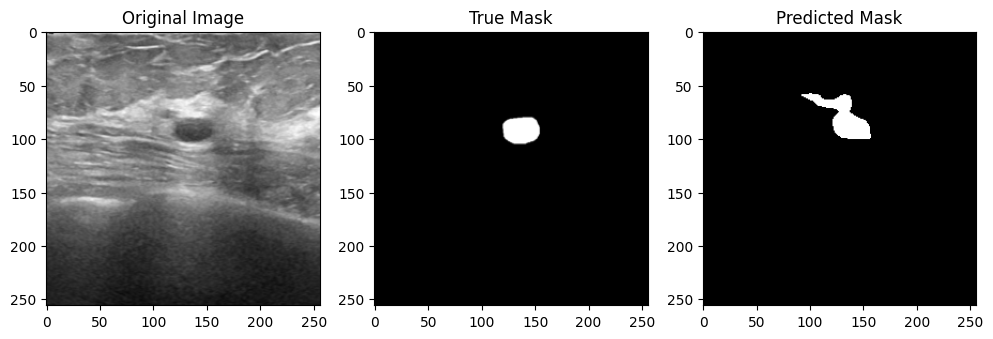

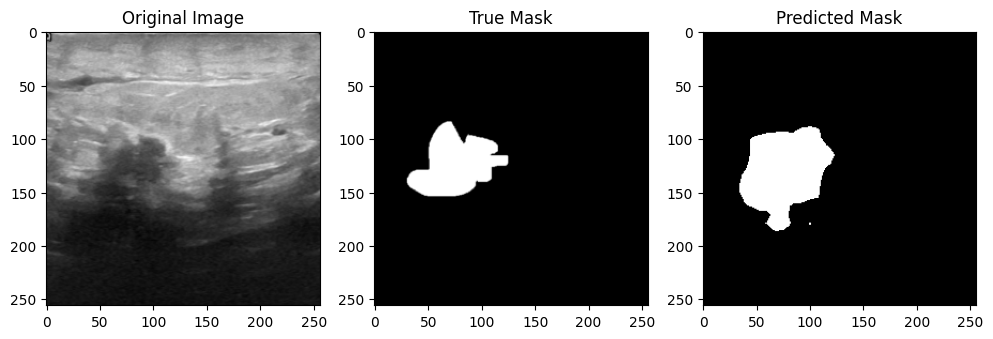

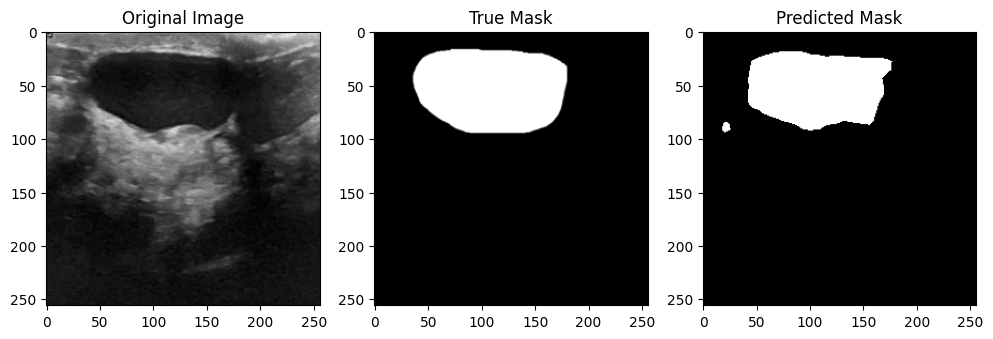

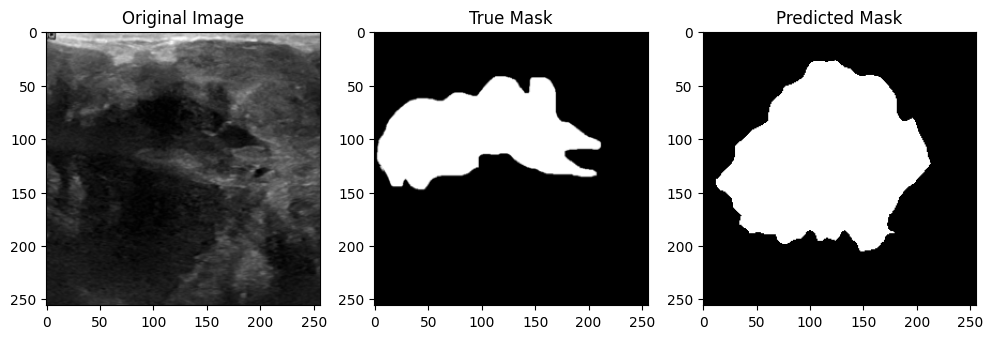

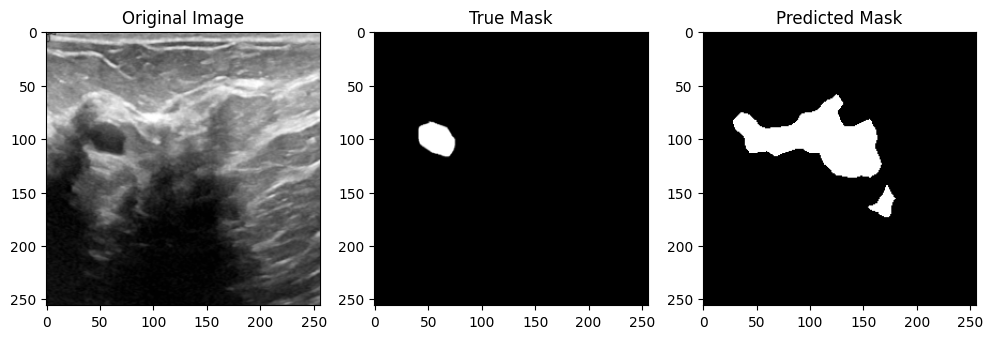

In [ ]:
def visualize_predictions(test_loader, model, device, num_images=15):
    model.eval()
    images_so_far = 0

    with torch.no_grad():
        for images, masks in test_loader:
            images = images.to(device)
            masks = masks.to(device)

            outputs = model(images)['out']
            outputs = torch.sigmoid(outputs)
            outputs = outputs.cpu()

            for i in range(images.size(0)):
                images_so_far += 1
                image = images.cpu().data[i]
                true_mask = masks.cpu().data[i]
                pred_mask = outputs.data[i]

                image = image.permute(1, 2, 0).numpy()
                true_mask = true_mask.squeeze().numpy()
                pred_mask = (pred_mask.squeeze().numpy() > threshold).astype(np.uint8)

                plt.figure(figsize=(12, 6))

                plt.subplot(1, 3, 1)
                plt.title('Original Image')
                plt.imshow(image, cmap='gray')

                plt.subplot(1, 3, 2)
                plt.title('True Mask')
                plt.imshow(true_mask, cmap='gray')

                plt.subplot(1, 3, 3)
                plt.title('Predicted Mask')
                plt.imshow(pred_mask, cmap='gray')

                plt.show()

                if images_so_far == num_images:
                    return

# Visualize some predictions
visualize_predictions(test_loader, model, device, num_images=15)


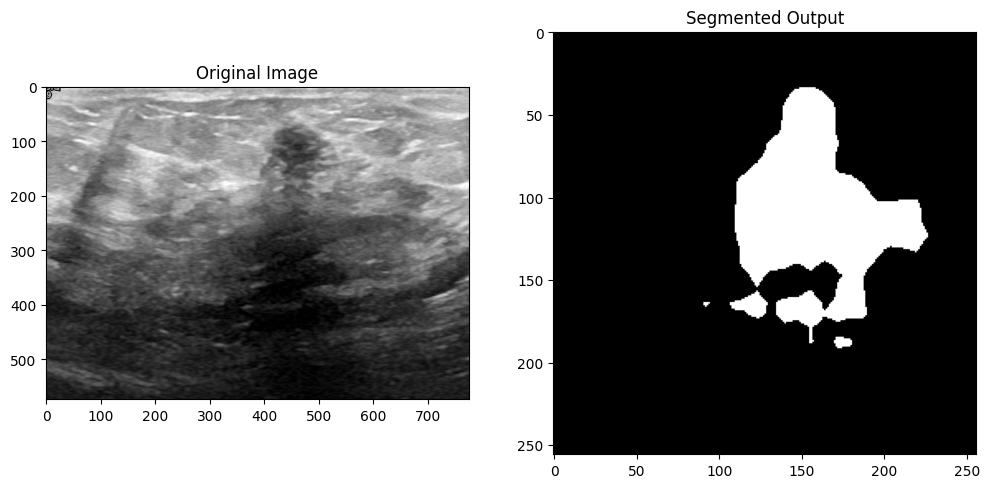

In [ ]:
# Load the trained model for inference
model.load_state_dict(torch.load('deeplabv3_resnet101_finetuned.pth'))
model.eval()

def segment_image(image_path, model, transform, device, threshold):
    image = Image.open(image_path).convert('RGB')
    image = transform(image).unsqueeze(0).to(device)
    with torch.no_grad():
        output = model(image)['out']
        output = torch.sigmoid(output)
        output = (output.cpu().squeeze().numpy() > threshold).astype(np.uint8)
        #(pred_mask.squeeze().numpy() > 0.5).astype(np.uint8)
        return output

# Example of using the model for segmentation
ultrasound_image_path = '/content/drive/MyDrive/malignant_deleted/malignant (152).png'
segmented_output = segment_image(ultrasound_image_path, model, transform, device, threshold)

# Plot the original image and the segmented output
original_image = Image.open(ultrasound_image_path).convert('RGB')
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title('Original Image')
plt.imshow(original_image)
plt.subplot(1, 2, 2)
plt.title('Segmented Output')
plt.imshow(segmented_output, cmap='gray')
plt.show()
